# Analysing Fraudulent Transaction Data

## Table of Contents
* [Part 1 : Working with RDD](#part-1)  
    - [1.1 Data Preparation and Loading](#1.1)  
    - [1.2 Data Partitioning in RDD](#1.2)  
    - [1.3 Query/Analysis](#1.3)  
* [Part 2 : Working with DataFrames](#2-dataframes)  
    - [2.1 Data Preparation and Loading](#2-dataframes)  
    - [2.2 Query/Analysis](#2.2)  
* [Part 3 :  RDDs vs DataFrame vs Spark SQL](#part-3)  

# Part 1 : Working with RDDs (30%) <a class="anchor" name="part-1"></a>
## 1.1 Working with RDD
In this section, you will need to create RDDs from the given datasets, perform partitioning in these RDDs and use various RDD operations to answer the queries. 

1.1.1 Data Preparation and Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkContext object using SparkSession. To create a SparkSession you first need to build a SparkConf object that contains information about your application, use Melbourne time as the session timezone. Give an appropriate name for your application and run Spark locally with 4 cores on your machine. 

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

#Creating a SparkConf object
conf = SparkConf().setAppName("MySparkApp")\
                  .setMaster("local[4]")\
                  .set("spark.sql.session.timeZone", "Australia/Melbourne")

#followed by a SparkSession using the SparkConf
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# assigning a variable for SparkContext from the SparkSession
sc = spark.sparkContext

1.1.2 Load csv files into multiple RDDs.

In [3]:
# Loading CSV files into RDDs
transactions_rdd = sc.textFile("transactions.csv")
merchants_rdd = sc.textFile("merchant.csv")
customers_rdd = sc.textFile("customers.csv")
categories_rdd = sc.textFile("category.csv")
geolocations_rdd = sc.textFile("geolocation.csv")

# Transforming each line into a list of values
transactions_rdd = transactions_rdd.map(lambda line: line.split(","))
merchant_rdd = merchants_rdd.map(lambda line: line.split(","))
customers_rdd = customers_rdd.map(lambda line: line.split(","))
category_rdd = categories_rdd.map(lambda line: line.split(","))
geolocation_rdd = geolocations_rdd.map(lambda line: line.split(","))

1.1.3 For each RDD, remove the header rows and display the total count and first 10 records. (Hint: You can use csv.reader to parse rows into RDDs.)

In [4]:
# Function to extract and filter the header row
def remove_header(rdd):
    header = rdd.first()  
    return rdd.filter(lambda line: line != header)  

# Function to display the total count and first 10 records of an RDD
def display_rdd_info(rdd, rdd_name):
    print(f"\n{rdd_name} RDD:")
    print(f"Total count: {rdd.count()}")  # Count the number of records
    print("First 10 records:")
    for record in rdd.take(10):
        print(record)

# Standard list of RDDs considered
rdd_list = [
    ("Transactions", transactions_rdd),
    ("Merchants", merchant_rdd),
    ("Customers", customers_rdd),
    ("Categories", category_rdd),
    ("Geolocations", geolocation_rdd)
]

# Excluding the header from each RDD to display the information
for rdd_name, rdd in rdd_list:
    rdd = remove_header(rdd)
    display_rdd_info(rdd, rdd_name)


Transactions RDD:
Total count: 22949835
First 10 records:
['"0c20530e90719213c442744161a1850b"', '1622367050', '87.18', '0', '"794-45-4364"', '46', '2641132', '12']
['"984fc48fc946605deefc9d0967582811"', '1609183538', '276.97', '0', '"436-80-2340"', '60', '2932280', '5']
['b13ff47c73689bc4c8320c0ce403b15d', '1655595319', '7.67', '0', '"385-77-6544"', '87', '2708770', '2']
['"7cffae35cab67d9415f9f22d91ca7acc"', '1613234460', '198.96', '0', '"450-56-1117"', '138', '1170872', '10']
['"22e01cb3403a4c7ce598ebe785e1e947"', '1605030979', '33.46', '0', '"397-54-0253"', '218', '2470519', '5']
['"1d174d018228efcd1d5800f768628904"', '1608989049', '2.74', '0', '"248-09-7729"', '222', '3436926', '9']
['"532536d65907e08d938cb31e3631ddd4"', '1650997797', '1.23', '0', '"277-12-7638"', '337', '3750746', '2']
['"32d76f65b7512afbdc99331ee96bc6d7"', '1649986601', '7.78', '0', '"615-63-3623"', '718', '3773961', '2']
['c3f29bca602c9e2e9a188567f06d632f', '1617032215', '218.8', '0', '"877-16-8226"', '747', '

In [5]:
# Function to understand the indices of the header 
def print_header_with_indices(rdd, rdd_name):
    header = rdd.first()  # The first row is already split into a list of column names
    print(f"\n{rdd_name} RDD Header (split into list with indices):")
    for index, column_name in enumerate(header):
        print(f"{index}: \"{column_name}\"")

# printing the headers with indices which will help to drop the required columns 
for rdd_name, rdd in rdd_list:
    print_header_with_indices(rdd, rdd_name)


Transactions RDD Header (split into list with indices):
0: ""id_transaction""
1: ""trans_timestamp""
2: ""amt""
3: ""is_fraud""
4: ""id_customer""
5: ""id_geolocation""
6: ""id_merchant""
7: ""id_category""

Merchants RDD Header (split into list with indices):
0: ""merchant""
1: ""id_geolocation""
2: ""id_merchant""

Customers RDD Header (split into list with indices):
0: ""id_customer""
1: ""cc_num""
2: ""firstname""
3: ""lastname""
4: ""gender""
5: ""address""
6: ""job""
7: ""dob""
8: ""acct_num""
9: ""id_geolocation""

Categories RDD Header (split into list with indices):
0: ""category""
1: ""id_category""

Geolocations RDD Header (split into list with indices):
0: ""city""
1: ""state""
2: ""zip""
3: ""lat""
4: ""long""
5: ""id_geolocation""
6: ""population""


1.1.4 Drop personal information columns from RDDs: cc_num, firstname, lastname, address. 

In [6]:
# implementing inbuilt map function to retain only the necessary columns & exculding the above mentioned 
customers_rdd = customers_rdd.map(lambda field: (field[0], field[4], field[6], field[7], field[8], field[9]))

# Verify the result by printing the first few records
print("\nCustomers RDD after removing personal information:")
for record in customers_rdd.take(10):
    print(record)


Customers RDD after removing personal information:
('"id_customer"', '"gender"', '"job"', '"dob"', '"acct_num"', '"id_geolocation"')
('"263-99-6044"', 'F', 'Risk manager', '"2005-05-30"', '376443331852', '6339')
('"292-61-7844"', 'M', 'Trading standards officer', '"2003-04-19"', '870143739098', '6200')
('"491-28-3311"', 'F', 'Optometrist', '"2002-04-17"', '965855026307', '3547')
('"826-23-1754"', 'F', 'Banker', '"2001-07-15"', '11324746755', '6302')
('"172-11-9264"', 'F', 'Sports coach', '"2003-11-21"', '113495175185', '5227')
('"150-95-7922"', 'F', 'Medical secretary', '"2006-03-06"', '719783599768', '4047')
('"841-99-2980"', 'M', 'Toxicologist', '"2005-07-01"', '908554315130', '6271')
('"705-41-6699"', 'F', 'Product manager', '"2003-01-23"', '772162574642', '6302')
('"016-22-4524"', 'F', '"Loss adjuster', ' chartered"', '"2001-08-26"', '982712248618')


### 1.2 Data Partitioning in RDD <a class="anchor" name="1.2"></a>
1.2.1 For each RDD, print out the total number of partitions and the number of records in each partition.

In [7]:
# Function to uunderstand data partition for each created RDD
def analyze_partitions(rdd, rdd_name):
    print(f"\nAnalyzing {rdd_name} RDD:")
    partition_sizes = rdd.glom().map(len).collect()
    for i, size in enumerate(partition_sizes):
        print(f"Partition {i} has {size} records.")
    return partition_sizes

# Calling the function to print the  partitions and it's records. 
for rdd_name, rdd in rdd_list:
    analyze_partitions(rdd, rdd_name)


Analyzing Transactions RDD:
Partition 0 has 409655 records.
Partition 1 has 409552 records.
Partition 2 has 409551 records.
Partition 3 has 409568 records.
Partition 4 has 409556 records.
Partition 5 has 409615 records.
Partition 6 has 409623 records.
Partition 7 has 409562 records.
Partition 8 has 409556 records.
Partition 9 has 409568 records.
Partition 10 has 409558 records.
Partition 11 has 409590 records.
Partition 12 has 409620 records.
Partition 13 has 409626 records.
Partition 14 has 409575 records.
Partition 15 has 409576 records.
Partition 16 has 409570 records.
Partition 17 has 409576 records.
Partition 18 has 409544 records.
Partition 19 has 409653 records.
Partition 20 has 409581 records.
Partition 21 has 409577 records.
Partition 22 has 409557 records.
Partition 23 has 409565 records.
Partition 24 has 409576 records.
Partition 25 has 409604 records.
Partition 26 has 409617 records.
Partition 27 has 409570 records.
Partition 28 has 409541 records.
Partition 29 has 409582 

1.2.2 Answer the following questions:   
a) How many partitions do the above RDDs have?   
b) How is the data in these RDDs partitioned by default, when we do not explicitly specify any partitioning strategy? Can you explain why it is partitioned in this number?   
c) Assuming we are querying the dataset based on transaction date, can you think of a better strategy to partition the data based on your available hardware resources?

### a) The transactions rdd has 56 partitions, followed by merchant rdd with 4 partitions and customers, categories and gelocations rdd's have 2 partitions each. 

### b) Spark splits data based on its size and available resources. If no strategy is specifically stated, the division is random and equal. Since there is data skewness, considering the volume of data the spark has decided to give more partitions for the transaction CSV since it has more data when compared to the other data files. 

### c) We can implement the range data partitioning where the partition takes place based on transaction date 

1.2.3 Create a user defined function (UDF) to transform trans_timestamp to ISO format(YYYY-MM-DD hh:mm:ss), then call the UDF and add a new column trans_datetime.

In [8]:
import datetime
import logging

# Initialize logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Transforming the time stamp to the ISO format
def transform_timestamp(record):
    try:
        # Considering the index of timestamp column in the RDD
        trans_timestamp = record[1]
        
        # Conversion of timestamp to ISO 
        trans_datetime = datetime.datetime.fromtimestamp(int(trans_timestamp)).strftime('%Y-%m-%d %H:%M:%S')
        
        # trans_datetime appended to the original record and returned
        return record + [trans_datetime]
    except Exception as e:
        logger.error(f"Error processing record {record}: {e}")
        # incase if the records has none
        return record + [None]

# applyting the transfromation using the inbuilt map function 
transactions_rdd_with_datetime = transactions_rdd.map(transform_timestamp)

# displaying the outputs to verify the transformation. 
try:
    for record in transactions_rdd_with_datetime.take(10):
        print(record)
except Py4JJavaError as e:
    logger.error(f"Error occurred during take(): {e}")


['"id_transaction"', '"trans_timestamp"', '"amt"', '"is_fraud"', '"id_customer"', '"id_geolocation"', '"id_merchant"', '"id_category"', None]
['"0c20530e90719213c442744161a1850b"', '1622367050', '87.18', '0', '"794-45-4364"', '46', '2641132', '12', '2021-05-30 09:30:50']
['"984fc48fc946605deefc9d0967582811"', '1609183538', '276.97', '0', '"436-80-2340"', '60', '2932280', '5', '2020-12-28 19:25:38']
['b13ff47c73689bc4c8320c0ce403b15d', '1655595319', '7.67', '0', '"385-77-6544"', '87', '2708770', '2', '2022-06-18 23:35:19']
['"7cffae35cab67d9415f9f22d91ca7acc"', '1613234460', '198.96', '0', '"450-56-1117"', '138', '1170872', '10', '2021-02-13 16:41:00']
['"22e01cb3403a4c7ce598ebe785e1e947"', '1605030979', '33.46', '0', '"397-54-0253"', '218', '2470519', '5', '2020-11-10 17:56:19']
['"1d174d018228efcd1d5800f768628904"', '1608989049', '2.74', '0', '"248-09-7729"', '222', '3436926', '9', '2020-12-26 13:24:09']
['"532536d65907e08d938cb31e3631ddd4"', '1650997797', '1.23', '0', '"277-12-7638"'

### 1.3 Query/Analysis <a class="anchor" name="1.3"></a>
For this part, write relevant RDD operations to answer the following queries.

1.3.1 Calculate the summary of fraudulent transactions amount for each year, each month. Print the results in tabular format.

In [9]:
#Will help in reducing and summing amounts based on the key 
from operator import add

# First we filter out the fraud transactions before we proceed with the calcualtion 
fraudulent_transactions = transactions_rdd_with_datetime.filter(lambda record: record[3] == '1')

# Step 2: Map to ((year, month), amount)
def extract_year_month_amount(record):
    trans_datetime = record[-1]  # considering only the last element in the record 
    year, month, _ = trans_datetime.split('-') # negating day to consider only month and year
    amount = float(record[2])  
    return ((year, month), amount)

fraudulent_transactions_by_month = fraudulent_transactions.map(extract_year_month_amount)

# For each (year, month), sum all the corresponding amounts
summary_by_month = fraudulent_transactions_by_month.reduceByKey(add)

# Collect the results from the RDD into a list
results = summary_by_month.collect()

# Print the results in tabular format
print(f"{'Year':<10}{'Month':<10}{'Total Fraudulent Amount':<20}")
print("="*40)
for (year, month), total_amount in sorted(results):
    print(f"{year:<10}{month:<10}{total_amount:<20.2f}")

Year      Month     Total Fraudulent Amount
2020      01        898993.87           
2020      02        1055068.69          
2020      03        864818.53           
2020      04        797646.98           
2020      05        925864.70           
2020      06        983224.85           
2020      07        904102.03           
2020      08        1031171.33          
2020      09        895572.70           
2020      10        917590.31           
2020      11        876092.53           
2020      12        1047136.05          
2021      01        925229.73           
2021      02        789827.07           
2021      03        892832.58           
2021      04        907938.06           
2021      05        967478.79           
2021      06        883641.08           
2021      07        997994.13           
2021      08        935016.09           
2021      09        868437.49           
2021      10        1008533.07          
2021      11        789345.70           
2021      12 

1.3.2 List 20 mechants that suffered the most from fraudulent activities(i.e. 20 highest amount of monetary loss).

In [16]:
from operator import add

# First we filter out the fraud transactions before we proceed with the calcualtion 
#For each transaction T, if T.is_fraud == 1, keep the transaction.
fraudulent_transactions = transactions_rdd_with_datetime.filter(lambda record: record[3] == '1')

# Get the merchant ID from the 6th field and remove any surrounding spaces/quotes.
def map_merchant_amount(record):
    id_merchant = record[6].strip()  
    amount = float(record[2])  
    return (id_merchant, amount)

#For each fraudulent transaction T, extract T.id_merchant and T.amount.
merchant_amounts = fraudulent_transactions.map(map_merchant_amount)

# Aggregate the amounts by merchant ID
total_amounts_by_merchant_id = merchant_amounts.reduceByKey(add)

# Load the merchant.csv file into an RDD, loading to avoid error conflicts. 
merchant_rdd = sc.textFile("merchant.csv")
header = merchant_rdd.first()  # Extract the header
merchant_rdd = merchant_rdd.filter(lambda line: line != header)

# Clean the merchant RDD to (id_merchant, merchant_name)
def clean_merchant(record):
    fields = record.split(",")
    if len(fields) >= 2:
        id_merchant = fields[1].strip()  
        merchant_name = fields[0].strip().replace('"', '')  
        return (id_merchant, merchant_name)
    else:
        return None
# Apply the clean_merchant function to each record in the merchant RDD and filter out any invalid records (i.e., None).
cleaned_merchant_rdd = merchant_rdd.map(clean_merchant).filter(lambda x: x is not None)

# Joining total amounts with merchant names
total_amounts_by_merchant_name = total_amounts_by_merchant_id.join(cleaned_merchant_rdd) \
    .map(lambda x: (x[1][1], x[1][0]))  # (merchant_name, total_amount)

# Aggregating by merchant to get total loss for each company
total_amounts_by_company = total_amounts_by_merchant_name.reduceByKey(add)

# total amount in descending order and take the top 20 merchants
top_20_merchants = total_amounts_by_company.takeOrdered(20, key=lambda x: -x[1])

# Printing the results
print(f"{'Company (Merchant Name)':<40}{'Total Fraudulent Loss (USD)':<20}")
print("="*60)
for merchant_name, total_loss in top_20_merchants:
    print(f"{merchant_name:<40}${total_loss:.2f}")


Company (Merchant Name)                 Total Fraudulent Loss (USD)
Kunze Inc                               $46912.29
Nader-Maggio                            $46902.51
Schumm PLC                              $46902.51
Kutch and Sons                          $46616.18
Connelly-Carter                         $46519.37
Kihn Inc                                $46513.77
Kiehn-Emmerich                          $46498.79
Rempel Inc                              $46464.95
Nolan-Williamson                        $46364.74
Botsford Ltd                            $46357.12
Koepp-Witting                           $46303.54
Lockman Ltd                             $46279.38
Cole PLC                                $46251.12
Deckow-O'Conner                         $46248.81
Champlin-Casper                         $46233.08
Conroy-Emard                            $46233.08
Sawayn PLC                              $46233.08
Fahey Inc                               $46233.08
Kub PLC                         

## Part 2. Working with DataFrames (45%) <a class="anchor" name="2-dataframes"></a>
In this section, you need to load the given datasets into PySpark DataFrames and use DataFrame functions to answer the queries.
### 2.1 Data Preparation and Loading

2.1.1. Load the CSV files into separate dataframes. When you create your dataframes, please refer to the metadata file and think about the appropriate data type for each column.

In [17]:
from pyspark.sql import SparkSession

# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("DataFrame Loading Task") \
    .getOrCreate()

# Step 2: Load CSV files into DataFrames without specifying schema
transactions_df = spark.read.csv("transactions.csv", header=True, inferSchema=True)
customers_df = spark.read.csv("customers.csv", header=True, inferSchema=True)
merchants_df = spark.read.csv("merchant.csv", header=True, inferSchema=True)
categories_df = spark.read.csv("category.csv", header=True, inferSchema=True)
geolocations_df = spark.read.csv("geolocation.csv", header=True, inferSchema=True)

# Step 3: Verify the DataFrames
transactions_df.show(5, truncate=False)
customers_df.show(5, truncate=False)
merchants_df.show(5, truncate=False)
categories_df.show(5, truncate=False)
geolocations_df.show(5, truncate=False)

+--------------------------------+---------------+------+--------+-----------+--------------+-----------+-----------+
|id_transaction                  |trans_timestamp|amt   |is_fraud|id_customer|id_geolocation|id_merchant|id_category|
+--------------------------------+---------------+------+--------+-----------+--------------+-----------+-----------+
|0c20530e90719213c442744161a1850b|1622367050     |87.18 |0       |794-45-4364|46            |2641132    |12         |
|984fc48fc946605deefc9d0967582811|1609183538     |276.97|0       |436-80-2340|60            |2932280    |5          |
|b13ff47c73689bc4c8320c0ce403b15d|1655595319     |7.67  |0       |385-77-6544|87            |2708770    |2          |
|7cffae35cab67d9415f9f22d91ca7acc|1613234460     |198.96|0       |450-56-1117|138           |1170872    |10         |
|22e01cb3403a4c7ce598ebe785e1e947|1605030979     |33.46 |0       |397-54-0253|218           |2470519    |5          |
+--------------------------------+---------------+------

2.1.2 Display the schema of the dataframes.

In [19]:
transactions_df.printSchema()
customers_df.printSchema()
merchants_df.printSchema()
categories_df.printSchema()
geolocations_df.printSchema()

root
 |-- id_transaction: string (nullable = true)
 |-- trans_timestamp: integer (nullable = true)
 |-- amt: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- id_customer: string (nullable = true)
 |-- id_geolocation: integer (nullable = true)
 |-- id_merchant: integer (nullable = true)
 |-- id_category: integer (nullable = true)

root
 |-- id_customer: string (nullable = true)
 |-- cc_num: long (nullable = true)
 |-- firstname: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- address: string (nullable = true)
 |-- job: string (nullable = true)
 |-- dob: date (nullable = true)
 |-- acct_num: long (nullable = true)
 |-- id_geolocation: integer (nullable = true)

root
 |-- merchant: string (nullable = true)
 |-- id_geolocation: integer (nullable = true)
 |-- id_merchant: integer (nullable = true)

root
 |-- category: string (nullable = true)
 |-- id_category: integer (nullable = true)

root
 |-- city: string 

Think about: When the dataset is large, do you need all columns? How to optimize memory usage? Do you need a customized data partitioning strategy? (note: You don’t need to answer these questions.)

### 2.2 QueryAnalysis  <a class="anchor" name="2.2"></a>
Implement the following queries using dataframes. You need to be able to perform operations like filtering, sorting, joining and group by using the functions provided by the DataFrame API.   

2.2.1. Transform the “trans_timestamp” to multiple columns: trans_year, trans_month, trans_day, trans_hour(24-hour format). (note: you can reuse your UDF from part 1 or create a new one.)

In [20]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import udf
import datetime

# Defining the UDF to convert Unix timestamp to the desired date parts

def get_year(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).year

def get_month(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).month

def get_day(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).day

def get_hour(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp).hour

# Writing UDF's to variables 
udf_get_year = udf(get_year, IntegerType())
udf_get_month = udf(get_month, IntegerType())
udf_get_day = udf(get_day, IntegerType())
udf_get_hour = udf(get_hour, IntegerType())

# Applying the UDFs to create new columns
transactions_df = transactions_df \
    .withColumn("trans_year", udf_get_year(F.col("trans_timestamp"))) \
    .withColumn("trans_month", udf_get_month(F.col("trans_timestamp"))) \
    .withColumn("trans_day", udf_get_day(F.col("trans_timestamp"))) \
    .withColumn("trans_hour", udf_get_hour(F.col("trans_timestamp")))

# displaying the transformation 
transactions_df.select("trans_timestamp", "trans_year", "trans_month", "trans_day", "trans_hour").show(10)

+---------------+----------+-----------+---------+----------+
|trans_timestamp|trans_year|trans_month|trans_day|trans_hour|
+---------------+----------+-----------+---------+----------+
|     1622367050|      2021|          5|       30|         9|
|     1609183538|      2020|         12|       28|        19|
|     1655595319|      2022|          6|       18|        23|
|     1613234460|      2021|          2|       13|        16|
|     1605030979|      2020|         11|       10|        17|
|     1608989049|      2020|         12|       26|        13|
|     1650997797|      2022|          4|       26|        18|
|     1649986601|      2022|          4|       15|         1|
|     1617032215|      2021|          3|       29|        15|
|     1609250028|      2020|         12|       29|        13|
+---------------+----------+-----------+---------+----------+
only showing top 10 rows



In [21]:
from pyspark.sql import functions as F

# Converting Unix timestamp to UTC timestamp
transactions_df = transactions_df.withColumn(
    "utc_time",
    F.from_unixtime(F.col("trans_timestamp")).cast("timestamp")
)

# Converting UTC timestamp to Melbourne time
transactions_df = transactions_df.withColumn(
    "melbourne_time",
    F.from_utc_timestamp(F.col("utc_time"), "Australia/Melbourne")
)

# Droping the intermediate 'utc_time' column since it is not required.
transactions_df = transactions_df.drop("utc_time")

# Extracting year, month, day, and hour from Melbourne time
transactions_df = transactions_df \
    .withColumn("trans_year", F.year("melbourne_time")) \
    .withColumn("trans_month", F.month("melbourne_time")) \
    .withColumn("trans_day", F.dayofmonth("melbourne_time")) \
    .withColumn("trans_hour", F.hour("melbourne_time"))

# displaying the tranformation.
transactions_df.select(
    "trans_timestamp", 
    "melbourne_time", 
    "trans_year", 
    "trans_month", 
    "trans_day", 
    "trans_hour"
).show(10, truncate=False)

+---------------+-------------------+----------+-----------+---------+----------+
|trans_timestamp|melbourne_time     |trans_year|trans_month|trans_day|trans_hour|
+---------------+-------------------+----------+-----------+---------+----------+
|1622367050     |2021-05-31 05:30:50|2021      |5          |31       |5         |
|1609183538     |2020-12-29 17:25:38|2020      |12         |29       |17        |
|1655595319     |2022-06-19 19:35:19|2022      |6          |19       |19        |
|1613234460     |2021-02-14 14:41:00|2021      |2          |14       |14        |
|1605030979     |2020-11-11 15:56:19|2020      |11         |11       |15        |
|1608989049     |2020-12-27 11:24:09|2020      |12         |27       |11        |
|1650997797     |2022-04-27 14:29:57|2022      |4          |27       |14        |
|1649986601     |2022-04-15 21:36:41|2022      |4          |15       |21        |
|1617032215     |2021-03-30 13:36:55|2021      |3          |30       |13        |
|1609250028     

2.2.2. Calculate the total amount of fraudulent transactions for each hour. Show the result in a table and plot a bar chart.

+----------+------------------+
|trans_hour|total_fraud_amount|
+----------+------------------+
|0         |381445.31         |
|1         |417892.99000000005|
|2         |403231.68999999994|
|3         |430991.99         |
|4         |447647.10000000003|
|5         |450724.44         |
|6         |418971.51999999984|
|7         |421735.34         |
|8         |5294360.760000001 |
|9         |1.016169209E7     |
|10        |6074283.230000001 |
|11        |1843582.7500000002|
|12        |1827012.4099999997|
|13        |1989535.3699999996|
|14        |1027331.78        |
|15        |153623.16999999998|
|16        |135053.02         |
|17        |145336.47000000003|
|18        |144340.67         |
|19        |144448.36000000002|
+----------+------------------+
only showing top 20 rows



INFO:numexpr.utils:NumExpr defaulting to 4 threads.


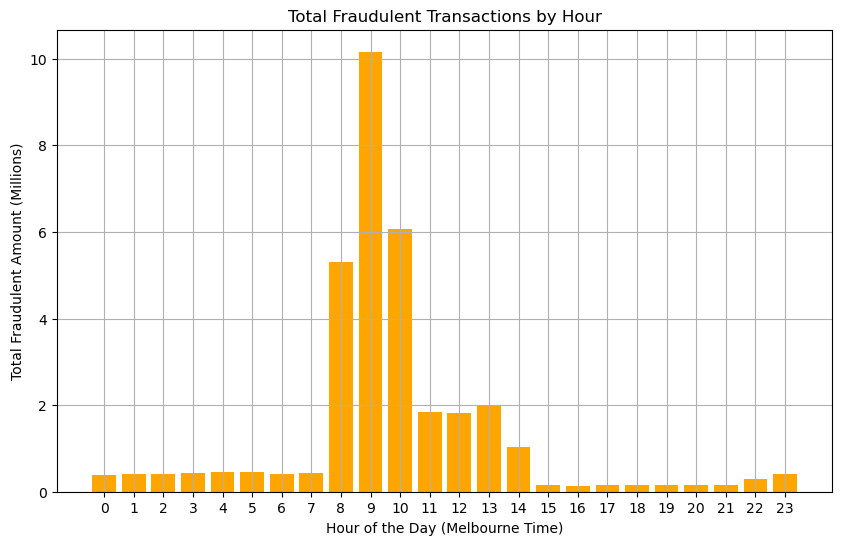

In [22]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Filter for fraudulent transactions
fraud_transactions_df = transactions_df.filter(F.col("is_fraud") == 1)

# Group the transactions by the hour (trans_hour) and calculate the total fraudulent amount per hour
fraud_by_hour_df = fraud_transactions_df.groupBy("trans_hour").agg(
    F.sum("amt").alias("total_fraud_amount")
)

# Sort the DataFrame by trans_hour 
fraud_by_hour_df = fraud_by_hour_df.orderBy("trans_hour")

# displaying the results in a table
fraud_by_hour_df.show(truncate=False)

# Convert the Spark DataFrame into a Pandas DataFrame for visualization
fraud_by_hour_pd = fraud_by_hour_df.toPandas()

# Converting y axis scale the total fraud amount to millions
fraud_by_hour_pd['total_fraud_amount_millions'] = fraud_by_hour_pd['total_fraud_amount'] / 1e6

# bar chart with the y-axis in millions
plt.figure(figsize=(10, 6))
plt.bar(fraud_by_hour_pd['trans_hour'], fraud_by_hour_pd['total_fraud_amount_millions'], color='orange')
plt.xlabel('Hour of the Day (Melbourne Time)')
plt.ylabel('Total Fraudulent Amount (Millions)')
plt.title('Total Fraudulent Transactions by Hour')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

2.2.3 Print number of small transactions(<=$100) from female who was born after 1990. 

In [23]:
from pyspark.sql import functions as F

# Filtering customers born after 1990 and female
filtered_customers_df = customers_df.filter(
    (F.col("gender") == "F") & 
    (F.year(F.col("dob")) > 1990)
)

# Joining transactions with filtered customers
joined_df = transactions_df.join(filtered_customers_df, on="id_customer", how="inner")

# Filter joined_df to keep only transactions where the transaction amount is less than or equal to $100.
small_transactions_df = joined_df.filter(F.col("amt") <= 100)

# Counting the number of transactions
small_transaction_count = small_transactions_df.count()

print(f"Number of small transactions (<= $100) from females born after 1990: {small_transaction_count}")


Number of small transactions (<= $100) from females born after 1990: 1889691


2.2.4 We consider a fraud-to-sales(F2S) ratio of 3% as a benchmark. If a merchant has F2S >= 3%, it is considered operating at very high rick. How many companies are operating at very high risk? (note: The answer should be a single number.)

In [24]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession


# oin the transactions and merchants DataFrames on id_merchant to add merchant details to each transaction
joined_df = transactions_df.join(merchants_df, on="id_merchant", how="inner")

# Group the fraudulent transactions by merchant and compute the total fraudulent amount for each merchant
fraud_amount_df = joined_df.filter(joined_df.is_fraud == 1) \
    .groupBy("merchant") \
    .agg(F.sum("amt").alias("total_fraud_amount"))

# Group all transactions by merchant and compute the total sales amount for each merchant.
total_sales_df = joined_df.groupBy("merchant") \
    .agg(F.sum("amt").alias("total_sales_amount"))

# Performing an outer join on the merchant column to include merchants with and without fraudulent transactions.
f2s_df = fraud_amount_df.join(total_sales_df, "merchant", "outer") \
    .fillna(0, subset=["total_fraud_amount", "total_sales_amount"])

# Calculating the the F2S ratio
f2s_df = f2s_df.withColumn("f2s_ratio", (f2s_df.total_fraud_amount / f2s_df.total_sales_amount) * 100)

# Selecting merchants where the F2S ratio is greater than or equal to 3%.
high_risk_merchants_df = f2s_df.filter(f2s_df.f2s_ratio >= 3)

# Counting the number of high-risk merchants
high_risk_company_count = high_risk_merchants_df.count()

print(f"Number of companies operating at very high risk: {high_risk_company_count}")

Number of companies operating at very high risk: 250


2.2.5 “Abbott and Adam Group” wants to know their total revenue(sum of non-fraud amt) in each state they operate, show the top 20 results by revenue in descending order. You output should include merchant name, state and total revenue. (note: Abbott and Adam group include all merchants who name start with “Abbott” or “Adam”.)

In [25]:
from pyspark.sql.functions import col, sum as spark_sum, desc

# Filtering Merchants Who Belong to "Abbott and Adam Group"
filtered_merchants_df = merchants_df.filter(
    (col("merchant").startswith("Abbott")) | (col("merchant").startswith("Adam"))
)

# Join transactions_df with filtered_merchants_df on id_merchant to include transactions related to the filtered merchants.
joined_df = transactions_df.join(filtered_merchants_df, "id_merchant")

# Filtering out the  Non-Fraudulent Transactions
non_fraud_df = joined_df.filter(col("is_fraud") == 0)

# Joining with Geolocation to Get State Information
joined_with_state_df = non_fraud_df.join(geolocations_df, "id_geolocation")

# Aggregating the total Revenue by Merchant and State
revenue_df = joined_with_state_df.groupBy("merchant", "state").agg(
    spark_sum("amt").alias("total_revenue")
)

# Sorting by Total Revenue in Descending Order and Show Top 20
top_20_revenue_df = revenue_df.orderBy(desc("total_revenue")).limit(20)

# Show the final result
top_20_revenue_df.show(truncate=False)


+--------------------------+-----+------------------+
|merchant                  |state|total_revenue     |
+--------------------------+-----+------------------+
|Abbott-Rogahn             |CA   |352865.9700000001 |
|Adams, Kovacek and Kuhlman|CA   |279898.79         |
|Adams-Barrows             |CA   |278485.78999999986|
|Abbott-Rogahn             |TX   |247959.91         |
|Adams-Barrows             |TX   |199538.5700000001 |
|Adams, Kovacek and Kuhlman|TX   |187685.3699999999 |
|Abbott-Rogahn             |NY   |182627.71         |
|Abbott-Rogahn             |FL   |178579.29000000004|
|Adams, Kovacek and Kuhlman|NY   |155427.12         |
|Adams-Barrows             |FL   |154059.63999999998|
|Adams, Kovacek and Kuhlman|FL   |150222.35000000003|
|Adams-Barrows             |NY   |145255.89999999997|
|Abbott-Rogahn             |IL   |119764.71999999996|
|Abbott-Rogahn             |PA   |118146.56000000001|
|Abbott-Rogahn             |OH   |105306.51999999999|
|Adams, Kovacek and Kuhlman|

2.2.6 For each year (2020-2022), aggregate the number(count) of fraudulent transactions every hour. Plot an appropriate figure and observe the trend. Write your observations from your plot (e.g. Is fraudulent activities increasing or decreasing? Are those frauds more active after midnight or during business hours?).

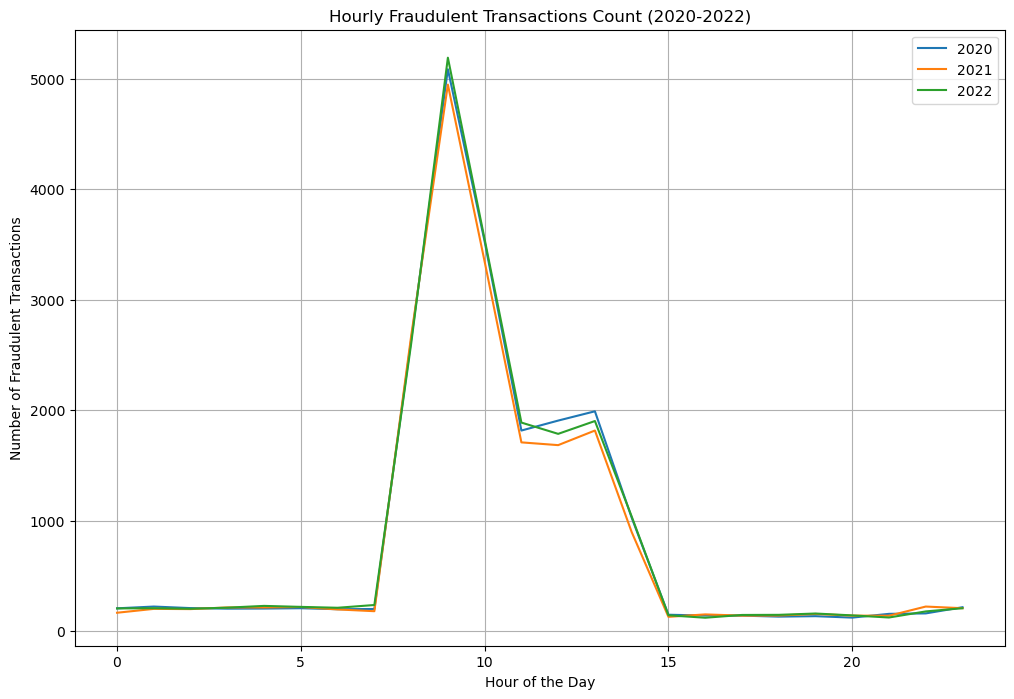

In [26]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

#Filtering  for fraudulent transactions
fraud_transactions_df = transactions_df.filter(F.col("is_fraud") == 1)

# Add a new column trans_year by extracting the year from the melbourne_time timestamp.
fraud_transactions_df = fraud_transactions_df.withColumn("trans_year", F.year(F.col("melbourne_time")))

# Filtering for years 2020 to 2022 redudant
filtered_fraud_df = fraud_transactions_df.filter(
    (F.col("trans_year") >= 2020) & (F.col("trans_year") <= 2022)
)

# Group the transactions by trans_year and trans_hour and count how many transactions occurred for each combination.
hourly_fraud_count_df = filtered_fraud_df.groupBy("trans_year", "trans_hour").agg(
    F.count("*").alias("fraud_count")
).orderBy("trans_year", "trans_hour")

# Converting the DataFrame to Pandas for plotting
hourly_fraud_count_pd = hourly_fraud_count_df.toPandas()

# plotting the data
plt.figure(figsize=(12, 8))

for year in range(2020, 2023):
    yearly_data = hourly_fraud_count_pd[hourly_fraud_count_pd['trans_year'] == year]
    plt.plot(yearly_data['trans_hour'], yearly_data['fraud_count'], label=f"{year}")

plt.title("Hourly Fraudulent Transactions Count (2020-2022)")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Fraudulent Transactions")
plt.legend()
plt.grid(True)
plt.show()


#### Most of the fraud transactions are taking place during the peak business hours with respect to melbourne timings, we can see spike of fraud transaction post 8AM and peaks at 9AM and gradually drops after 10AM, though the intensity is high until late afternoon the frequency of the fraud transaction gradually reduces post afternoon. 

### Part 3 RDDs vs DataFrame vs Spark SQL (25%) <a class="anchor" name="part-3"></a>
Implement the following queries using RDDs, DataFrame in SparkSQL separately. Log the  time taken for each query in each approach using the “%%time” built-in magic command in Jupyter Notebook and discuss the performance difference between these 3 approaches.

#### Query: <strong>We consider city with population < 50K as small(denoted as S); 50K-200K as medium(M), >200K as large(L). For each city type, using customer age bucket of 10(e.g. 0-9, 10-19, 20-29…), show the percentage ratio of fraudulent transactions in each age bucket.</strong>

In [30]:
from operator import add
from datetime import datetime
# Load the Transactions RDD
transactions_rdd = sc.textFile("transactions.csv")
transactions_header = transactions_rdd.first()  # Extract the header
transactions_rdd = transactions_rdd.filter(lambda line: line != transactions_header).map(lambda x: x.split(",")).map(lambda x: [i.strip() for i in x])

# Load the Merchants RDD
merchants_rdd = sc.textFile("merchant.csv")
merchants_header = merchants_rdd.first()  # Extract the header
merchants_rdd = merchants_rdd.filter(lambda line: line != merchants_header).map(lambda x: x.split(",")).map(lambda x: [i.strip() for i in x])

# Load the Customers RDD
customers_rdd = sc.textFile("customers.csv")
customers_header = customers_rdd.first()  # Extract the header
customers_rdd = customers_rdd.filter(lambda line: line != customers_header).map(lambda x: x.split(",")).map(lambda x: [i.strip() for i in x])

# Load the Geolocations RDD
geolocations_rdd = sc.textFile("geolocation.csv")
geolocations_header = geolocations_rdd.first()  # Extract the header
geolocations_rdd = geolocations_rdd.filter(lambda line: line != geolocations_header).map(lambda x: x.split(",")).map(lambda x: [i.strip() for i in x])


#### 3.1. RDD Implementation

In [56]:
%%time
# Defining a function that processes the date of birth to classify age into buckets.
def calculate_age_bucket(dob):
    try:
        dob_clean = dob.strip('"')
        current_year = datetime.now().year
        birth_year = int(dob_clean[:4])
        age = current_year - birth_year
        return f"{(age // 10) * 10}-{(age // 10) * 10 + 9}"
    except (ValueError, IndexError):
        return "Unknown"

# For each customer, map id_customer to their age bucket using the calculate_age_bucket function
customers_with_age_bucket = customers_rdd.map(lambda x: (x[0], calculate_age_bucket(x[7])))

# Joining fraudulent transactions with customers' age data using id_customer.
transactions_with_customers = fraudulent_transactions_rdd.map(lambda x: (x[4], (x[6], x[5])))
transactions_with_age = transactions_with_customers.join(customers_with_age_bucket)

# Classifying cities into small, medium, and large
def classify_city(population):
    try:
        pop_int = int(population.strip('"'))  # Handle quotes around population
        if pop_int < 50000:
            return 'S'
        elif 50000 <= pop_int <= 200000:
            return 'M'
        else:
            return 'L'
    except ValueError:
        return 'Unknown'  # If population can't be converted, return 'Unknown'

geolocations_with_city_type = geolocations_rdd.map(lambda x: (x[5], classify_city(x[6])))

# Join transactions with city type
transactions_with_city = transactions_with_age.map(lambda x: (x[1][0][0], (x[1][1], x[1][0][1])))
transactions_with_city_type = transactions_with_city.join(geolocations_with_city_type)

# For each transaction, map it to a (city_type, age_bucket) tuple, and reduce it by summing up all occurrences to get the fraud count per age group and city type.
fraud_count_by_city_age = transactions_with_city_type.map(lambda x: ((x[1][1], x[1][0][0]), 1)).reduceByKey(add)

# appending each transaction to its corresponding city type and count the total number of fraudulent transactions per city using reduceByKey(add).
total_fraud_per_city = transactions_with_city_type.map(lambda x: (x[1][1], 1)).reduceByKey(add)

# Joining to calculate percentage of fraud per age bucket and city type
fraud_count_by_city_age_modified = fraud_count_by_city_age.map(lambda x: (x[0][0], (x[0][1], x[1])))
fraud_percentage_by_city_age = fraud_count_by_city_age_modified.join(total_fraud_per_city) \
    .map(lambda x: ((x[0], x[1][0][0]), (x[1][0][1] / x[1][1]) * 100))

# display results
fraud_percentage_result_rdd = fraud_percentage_by_city_age.collect()
print(f"{'City Type':<10}{'Age Bucket':<15}{'Fraud Percentage (%)':<20}")
print("="*45)
for ((city_type, age_bucket), percentage) in fraud_percentage_result_rdd:
    print(f"{city_type:<10}{age_bucket:<15}{percentage:<20.2f}")

City Type Age Bucket     Fraud Percentage (%)
L         Unknown        25.00               
L         20-29          12.50               
L         80-89          4.17                
L         60-69          8.33                
L         70-79          4.17                
L         40-49          25.00               
L         30-39          12.50               
L         50-59          8.33                
M         20-29          4.17                
M         60-69          4.17                
M         Unknown        29.17               
M         50-59          4.17                
M         30-39          20.83               
M         90-99          8.33                
M         40-49          29.17               
S         40-49          9.68                
S         60-69          6.45                
S         80-89          1.61                
S         30-39          27.42               
S         Unknown        33.87               
S         20-29          6.45     

#### 3.2. DataFrame Implementation

In [54]:

%%time 
# Defining a UDF to calculate the age bucket
def calculate_age_bucket(dob):
    try:
        # Extract year from dob and calculate age (since dob is already a datetime object)
        current_year = datetime.now().year
        birth_year = dob.year  # Extract year from the datetime.date object
        age = current_year - birth_year
        
        # Returning the age bucket 
        return f"{(age // 10) * 10}-{(age // 10) * 10 + 9}"
    except (ValueError, AttributeError):
        # Incase of unknown format return Unknown
        return "Unknown"

# Convert the Python function into a Spark UDF for use in DataFrame operations.
udf_calculate_age_bucket = F.udf(calculate_age_bucket)

# Applying the UDF to calculate the age_bucket for each customer and create a new column in the DataFrame.
customers_df = customers_df.withColumn("age_bucket", udf_calculate_age_bucket(F.col("dob")))

# Filtering the fraudulent transactions
fraudulent_transactions_df = transactions_df.filter(F.col("is_fraud") == '1')

# Joining fraudulent transactions with customers on id_customer to get DOB and geolocation
fraud_with_customers_df = fraudulent_transactions_df.join(customers_df, on="id_customer", how="inner")

#  Defineing function to classify city type based on population
def classify_city(population):
    return when(F.col("population") < 50000, 'S').when((F.col("population") >= 50000) & (F.col("population") <= 200000), 'M').otherwise('L')

# Adding city_type column based on the population in geolocations dataframe
geolocations_df = geolocations_df.withColumn("city_type", classify_city(F.col("population")))

# Join fraudulent transactions with customer data based on the id_customer column.
fraud_with_city_df = fraud_with_customers_df.join(geolocations_df, on="id_geolocation", how="inner")

#  Group by city_type and age_bucket to get fraud counts
fraud_by_city_age_df = fraud_with_city_df.groupBy("city_type", "age_bucket").agg(F.count("*").alias("fraud_count"))

# Calculate total fraud transactions per city_type
total_fraud_by_city_df = fraud_with_city_df.groupBy("city_type").agg(F.count("*").alias("total_fraud"))

# Join the fraud count and total fraud data based on city_type.
fraud_percentage_df = fraud_by_city_age_df.join(total_fraud_by_city_df, on="city_type") \
    .withColumn("fraud_percentage", (F.col("fraud_count") / F.col("total_fraud")) * 100)

# displaying the final result
final_df = fraud_percentage_df.select("city_type", "age_bucket", "fraud_percentage")

print(f"{'City Type':<10}{'Age Bucket':<15}{'Fraud Percentage (%)':<20}")
print("="*45)
for row in final_df.collect():
    print(f"{row['city_type']:<10}{row['age_bucket']:<15}{row['fraud_percentage']:<20.2f}")


City Type Age Bucket     Fraud Percentage (%)
S         20-29          8.41                
S         90-99          3.73                
L         20-29          7.91                
M         40-49          18.52               
S         30-39          17.69               
S         80-89          5.19                
S         60-69          15.58               
S         70-79          9.00                
M         30-39          18.31               
L         40-49          19.05               
M         60-69          16.13               
L         70-79          8.37                
M         70-79          10.30               
L         60-69          16.43               
S         40-49          18.91               
M         80-89          5.63                
L         80-89          5.54                
L         30-39          17.15               
M         20-29          7.72                
M         90-99          3.14                
S         50-59          21.50    

#### 3.3. Spark SQL Implementation

In [51]:

%%time 

# Adding city_type column to geolocations based on population
geolocations_df = geolocations_df.withColumn(
    "city_type", 
    when(geolocations_df.population < 50000, 'S')
    .when((geolocations_df.population >= 50000) & (geolocations_df.population <= 200000), 'M')
    .otherwise('L')
)

# Registering DataFrames as SQL tables to enable SQL queries.
transactions_df.createOrReplaceTempView("transactions")
customers_df.createOrReplaceTempView("customers")
geolocations_df.createOrReplaceTempView("geolocations")

# Create a query to calculate age buckets by extracting the year of birth and grouping customers into 10-year intervals.
age_bucket_query = """
    SELECT
        id_customer,
        dob,
        CASE 
            WHEN dob IS NULL THEN 'Unknown'
            ELSE CONCAT(FLOOR((YEAR(CURRENT_DATE()) - YEAR(dob)) / 10) * 10, '-', FLOOR((YEAR(CURRENT_DATE()) - YEAR(dob)) / 10) * 10 + 9)
        END AS age_bucket
    FROM customers
"""

# Execute the query and store the results in a new DataFrame
age_bucket_df = spark.sql(age_bucket_query)
age_bucket_df.createOrReplaceTempView("customers_with_age_bucket")

# Join transactions, customers (with age buckets), and geolocation data, filtering only fraudulent transactions.
fraud_with_customers_query = """
    SELECT 
        f.id_transaction,
        f.is_fraud,
        c.age_bucket,
        g.city_type
    FROM transactions f
    JOIN customers_with_age_bucket c ON f.id_customer = c.id_customer
    JOIN geolocations g ON f.id_geolocation = g.id_geolocation
    WHERE f.is_fraud = '1'
"""

# Run the fraud query and store it in a new SQL view for further processing.
fraud_with_customers_df = spark.sql(fraud_with_customers_query)
fraud_with_customers_df.createOrReplaceTempView("fraud_with_customers")

# Group the fraud data by city type and age bucket and count the transactions.
fraud_count_query = """
    SELECT 
        city_type,
        age_bucket,
        COUNT(*) AS fraud_count
    FROM fraud_with_customers
    GROUP BY city_type, age_bucket
"""

# Execute the fraud count query and register it as a new SQL view.
fraud_count_df = spark.sql(fraud_count_query)
fraud_count_df.createOrReplaceTempView("fraud_count_by_city_age")

# Calculating totalfraud per city type
total_fraud_query = """
    SELECT 
        city_type,
        COUNT(*) AS total_fraud
    FROM fraud_with_customers
    GROUP BY city_type
"""

# Execute the query
total_fraud_df = spark.sql(total_fraud_query)
total_fraud_df.createOrReplaceTempView("total_fraud_by_city")

# Calculating the fraud percentage by age bucket and city type
fraud_percentage_query = """
    SELECT 
        f.city_type,
        f.age_bucket,
        (f.fraud_count / t.total_fraud) * 100 AS fraud_percentage
    FROM fraud_count_by_city_age f
    JOIN total_fraud_by_city t ON f.city_type = t.city_type
"""

# execute to display the final result
result_df = spark.sql(fraud_percentage_query)
result_df.show(truncate=False)

+---------+----------+------------------+
|city_type|age_bucket|fraud_percentage  |
+---------+----------+------------------+
|S        |20-29     |8.407914976926303 |
|S        |90-99     |3.726751503286254 |
|L        |20-29     |7.911556400069096 |
|M        |40-49     |18.521018717397975|
|S        |30-39     |17.686337575164313|
|S        |80-89     |5.191581596979444 |
|S        |60-69     |15.57824080548175 |
|S        |70-79     |8.995245420220948 |
|M        |30-39     |18.312365756366983|
|L        |40-49     |19.047619047619047|
|M        |60-69     |16.133783369131635|
|L        |70-79     |8.372200149709219 |
|M        |70-79     |10.303774163853943|
|L        |60-69     |16.427707721540855|
|S        |40-49     |18.909942665361488|
|M        |80-89     |5.627493096041731 |
|L        |80-89     |5.54499913629297  |
|L        |30-39     |17.147463580353545|
|M        |20-29     |7.720159558146671 |
|M        |90-99     |3.142068119054925 |
+---------+----------+------------

### 3.4 Which one is the easiest to implement in your opinion? Log the time taken for each query, and observe the query execution time, among RDD, DataFrame, SparkSQL, which is the fastest and why? Please include proper reference. (Maximum 500 words.)

In my opinion, I find SparkSQL easiest since the operation on the data set can be easily implemented with concepts of SQL queries, join operations, and features which can be implemented easily, however implementing data frames is much faster and more convenient when compared to SparkSQL and RDD, and below are the reason, 

With a wall time of 10.4 seconds, DataFrames are preferably the fastest approach that can be implemented. However, SparkSQL is a little close concerning wall time(12.5s), data frames are more likely to be considered due to less overhead. The wall time relating to SparkSQL is slightly higher than the data frame because SparkSql translates SQL queries into DataFrames operation before execution. Still, data frames provide direct access to the spark's query engine resulting in faster performance. 

Why data frames are quick?

Catalyst Optimizer: DataFrames benefit from Sparks catalyst optimizer, which automatically optimizes the execution of queries by applying predicate pushdowns, join optimizations and query plan purning which leads to effiecient query exceution. [1]

Efficient Memory Usage: DataFrames avoids JAVA object serialization which requires RDDs, which minimizes overhead resulting in quick query execution. [2]

Tungsten Execution Engine: with use of TEE  in data frames memory and CPU usage is optimized, tungsten provides vectorized execution and cache-aware computation which significantly improves speed of operations over RDD. [2]

RDD's are the slowest as they do not benefit from the optmizations provided by the catalyst optimizer or the tungsten execution engine, they also give users low level control over the operations but at the cost of performance. [2]

### References

1. 
Baeldung. (2023). Spark RDD vs DataFrame vs Dataset. Retrieved September 4, 2024, from https://www.baeldung.com/java-spark-dataframe-dataset-rdd

2. 
DataFlair. (2023). Apache Spark RDD vs DataFrame vs Dataset. Retrieved September 4, 2024, from https://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset/


Armbrust, M., Huai, Y., Liang, C., Xin, R., & Zaharia, M. (2015). Deep Dive into Spark SQL’s Catalyst Optimizer. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html

Damji, J. (2016). A Tale of Three Apache Spark APIs: RDDs, DataFrames, and Datasets. Retrieved September 28, 2017, from https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html

Data Flair (2017a). Apache Spark RDD vs DataFrame vs DataSet. Retrieved September 28, 2017, from http://data-flair.training/blogs/apache-spark-rdd-vs-dataframe-vs-dataset

Prakash, C. (2016). Apache Spark: RDD vs Dataframe vs Dataset. Retrieved September 28, 2017, from http://why-not-learn-something.blogspot.com.au/2016/07/apache-spark-rdd-vs-dataframe-vs-dataset.html

Xin, R., & Rosen, J. (2015). Project Tungsten: Bringing Apache Spark Closer to Bare Metal. Retrieved September 30, 2017, from https://databricks.com/blog/2015/04/28/project-tungsten-bringing-spark-closer-to-bare-metal.html